# Technical indicators

In [214]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ta import momentum, trend, volume
from alpha_vantage.techindicators import TechIndicators
from dotenv import load_dotenv
from datetime import datetime, timedelta
from alpha_vantage import timeseries


load_dotenv()
stock = 'AMD'

key = os.environ["ALPHA_VANTAGE_KEY"]


## Load data from file or create new file

In [215]:
try:
    df = pd.read_csv(f"{stock}.csv", index_col=0, parse_dates=[0])
    latest_timestamp = datetime.fromtimestamp(df.index[0].timestamp()).date()
    yesterday = datetime.now().date() - timedelta(days=1)
    if latest_timestamp != yesterday:
        raise Exception
except Exception:
    key = os.environ["ALPHA_VANTAGE_KEY"]
    ts = timeseries.TimeSeries(key=key, output_format="pandas")
    df, _ = ts.get_daily_adjusted(symbol=stock, outputsize="full")
    df.to_csv(f"{stock}.csv")

In [216]:
date_range = "2019-01-01"
df_recent = df[df.index > date_range]

## SMA - Simple Moving Average

In [217]:
def get_sma(close, window=12, fillna=False):
    return trend.sma_indicator(close=close, window=window, fillna=fillna)

# Reverse the dataset to put in the oldest values first
sma = get_sma(df['5. adjusted close'][::-1])

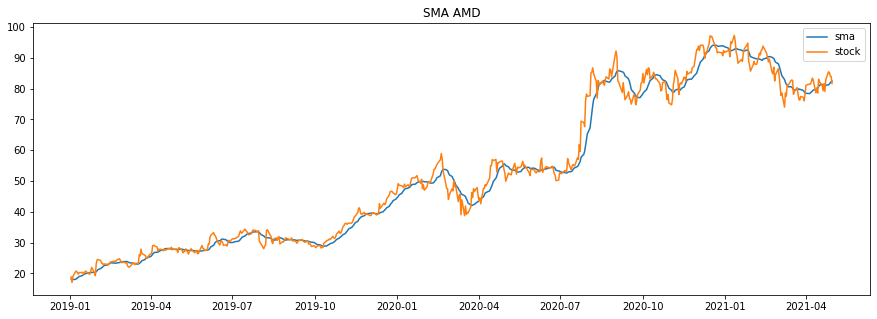

In [218]:
# Plot
sma_recent = sma[sma.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(sma_recent.index, sma_recent, label="sma")
plt.plot(df_recent.index, df_recent['5. adjusted close'], label="stock")
plt.legend()
plt.title(f"SMA {stock}")
plt.show()

## EMA - Exponential Moving Average

In [219]:
def get_ema(close, window=12, fillna=False):
    return trend.ema_indicator(close=close, window=window, fillna=fillna)


# Reverse the dataset to put in the oldest values first
ema = get_ema(df['5. adjusted close'][::-1])

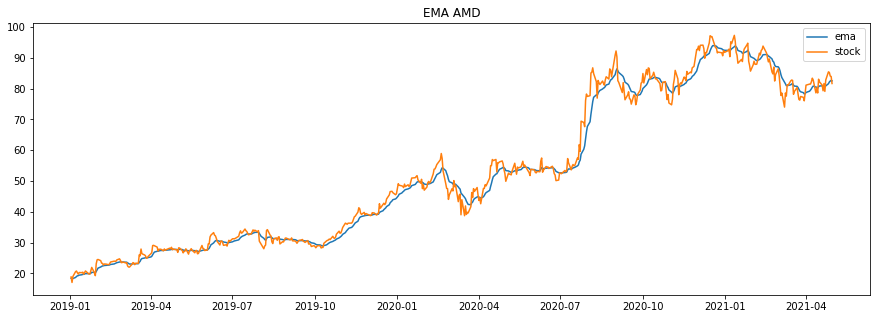

In [220]:
# Plot
ema_recent = ema[ema.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(ema_recent.index, ema_recent, label='ema')
plt.plot(df_recent.index, df_recent['5. adjusted close'], label="stock")
plt.legend()
plt.title(f"EMA {stock}")
plt.show()

## ROC - Rate of Change

In [221]:
def get_roc(close, window=12, fillna=False):
    return momentum.roc(close, window=window, fillna=False)


roc = get_roc(df['5. adjusted close'][::-1])

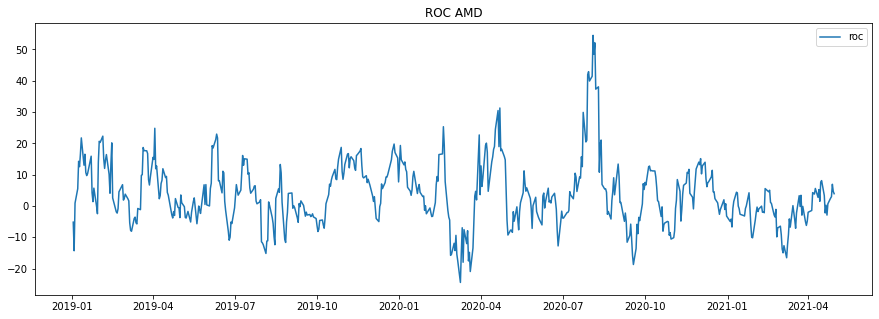

In [222]:
# Plot 
roc_recent = roc[roc.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(roc_recent.index, roc_recent, label='roc')
plt.legend()
plt.title(f"ROC {stock}")
plt.show()

## RSI - Relative Strength Indicator
\> 70 = Overbought  
< 30 = Oversold

In [223]:
def get_rsi(close, window=14, fillna=False):
    return momentum.rsi(close, window=window, fillna=False)

rsi = get_rsi(df['5. adjusted close'][::-1])

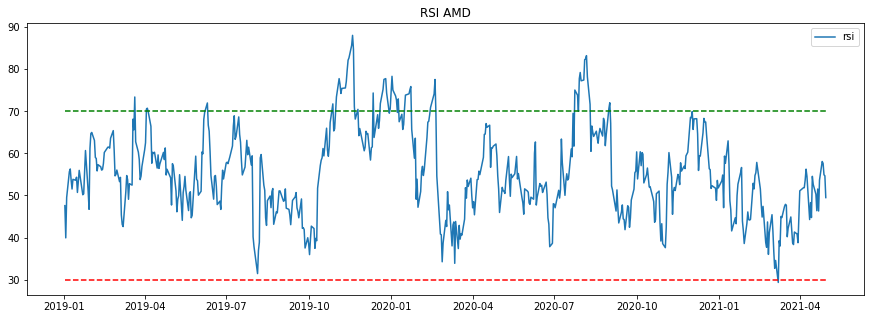

In [224]:
# Plot
rsi_recent = rsi[rsi.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(rsi_recent.index, rsi_recent, label='rsi')
plt.plot(rsi_recent.index, np.full((rsi_recent.size),70), "g--")
plt.plot(rsi_recent.index, np.full((rsi_recent.size),30), "r--")
# plt.plot(df.index, df['5. adjusted close'], label="stock")
plt.legend()
plt.title(f"RSI {stock}")
plt.show()

In [225]:
df.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. adjusted close',
       '6. volume', '7. dividend amount', '8. split coefficient'],
      dtype='object')

## OBV - On-Balance Volume

In [226]:
def get_obv(close, volume_input, fillna=False):
    return volume.on_balance_volume(close=close, volume=volume_input, fillna=True)

obv = get_obv(close=df['5. adjusted close'][::-1],volume_input=df['6. volume'][::-1])

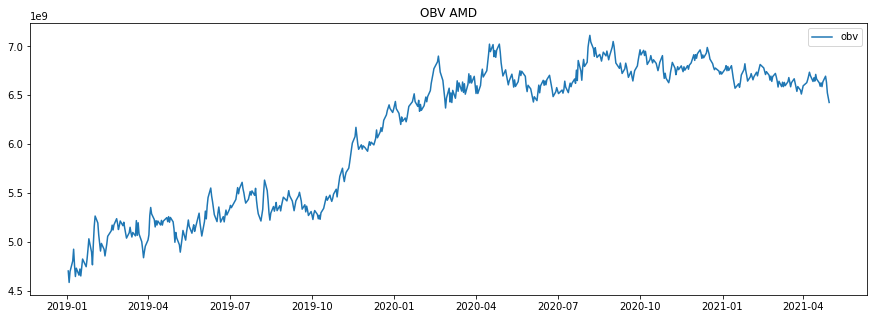

In [227]:
# Plot
obv_recent = obv[obv.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(obv_recent.index, obv_recent, label='obv')
plt.legend()
plt.title(f"OBV {stock}")
plt.show()

## Define comparison methods

In [228]:
def prepare_indicator(local_indicator, name, decimals):
    if not isinstance(local_indicator, pd.DataFrame):
        local_indicator = local_indicator.to_frame()
    local_indicator.rename(columns={f"{local_indicator.columns[0]}": f"{name}"}, inplace=True)
    local_indicator = local_indicator.round(decimals=decimals)
    local_indicator = local_indicator.dropna()
    return local_indicator


def calc_difference(local_indicator, av_indicator):
    difference= local_indicator.compare(av_indicator)
    if difference.size > 0:
        columns = difference.columns
        overall_difference = sum(abs(difference[columns[0]] - difference[columns[1]]))
        print(f"Overall difference in Alphavantage vs. local calculation: {overall_difference}")
    else:
        print("The data sets are identical")

In [229]:
ti = TechIndicators(key=key, output_format="pandas")

## Compare calculated SMA to Alphavantage SMA

In [230]:
sma_av, _ = ti.get_sma(symbol=stock, interval="daily", time_period=12, series_type="close")

ProxyError: HTTPSConnectionPool(host='www.alphavantage.co', port=443): Max retries exceeded with url: /query?function=SMA&symbol=AMD&interval=daily&time_period=12&series_type=close&apikey=TZVCYKR1K7KIPNYU (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001A92AC48E50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))

In [ ]:
sma = prepare_indicator(local_indicator=sma, name=f"{sma_av.columns[0]}", decimals=4)
calc_difference(local_indicator=sma, av_indicator=sma_av)

## Compare calculated EMA to Alphavantage EMA

In [ ]:
ema_av, _ = ti.get_ema(symbol=stock, interval="daily", time_period=12,series_type="close")

In [ ]:
ema = prepare_indicator(local_indicator=ema, name=f"{ema_av.columns[0]}", decimals=4)
calc_difference(local_indicator=ema, av_indicator=ema_av)

## Compare calculated ROC to Alphavantage ROC

In [ ]:
roc_av, _ = ti.get_roc(symbol=stock, interval="daily", time_period=12,series_type="close")

In [ ]:
roc = prepare_indicator(local_indicator=roc, name=f"{roc_av.columns[0]}", decimals=4)
calc_difference(local_indicator=roc, av_indicator=roc_av)

## Compare calculated RSI to Alphavantage RSI

In [ ]:
rsi_av, _ = ti.get_rsi(symbol=stock, interval="daily", time_period=14,series_type="close")

In [ ]:
# Plot
rsi_recent = rsi[rsi.index > date_range]
rsi_av_recent =rsi_av[rsi_av.index > date_range]


plt.figure(figsize=(15,5))
plt.plot(rsi_recent.index, rsi_recent, label='rsi')
plt.plot(rsi_av_recent.index, rsi_av_recent, label='rsi_av')
plt.plot(rsi_recent.index, np.full((rsi_recent.size),70), "g--")
plt.plot(rsi_recent.index, np.full((rsi_recent.size),30), "r--")
plt.legend()
plt.title(f"RSI {stock}")
plt.show()

In [ ]:
# Using a subset to calculate the difference, there seem to be a few broken datasets in the earlier alphavantage data

rsi_recent = prepare_indicator(local_indicator=rsi_recent, name=f"{rsi_av_recent.columns[0]}", decimals=4)
calc_difference(local_indicator=rsi_recent, av_indicator=rsi_av_recent)

## Compare calculated OBV to Alphavantage OBV

In [ ]:
obv_av, _ = ti.get_obv(symbol=stock, interval="daily")

In [ ]:
obv_recent = obv[obv.index > date_range]
obv_av_recent = obv_av[obv_av.index > date_range]

In [ ]:
#plot

plt.figure(figsize=(15,5))
plt.plot(obv.index, obv, label='obv')
plt.plot(obv_av.index, obv_av, label='obv_av')
plt.legend()
plt.title(f"OBV {stock}")
plt.show()

In [ ]:
obv = prepare_indicator(local_indicator=obv, name=f"{obv_av.columns[0]}", decimals=4)
calc_difference(local_indicator=obv, av_indicator=obv_av)